<a href="https://colab.research.google.com/github/Josephat-Onkoba/spam-filter-email-model/blob/main/spam_email_classification_and_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Emails
**Spam Emails Dataset for Classification and Filtering.**

**About Dataset**

***Overview:***

This dataset contains a collection of emails, categorized into two classes: "Spam" and "Non-Spam" (often referred to as "Ham"). These emails have been carefully curated and labeled to aid in the development of spam email detection models. Whether you are interested in email filtering, natural language processing, or machine learning, this dataset can serve as a valuable resource for training and evaluation.

***Context:***

Spam emails continue to be a significant issue, with malicious actors attempting to deceive users with unsolicited, fraudulent, or harmful messages. This dataset is designed to facilitate research, development, and testing of algorithms and models aimed at accurately identifying and filtering spam emails, helping protect users from various threats.

***Content:***

The dataset includes the following features:
Message: The content of the email, including the subject line and message body.
Category: Categorizes each email as either "Spam" or "Ham" (Non-Spam).

***Potential Use Cases:***

*   Email Filtering: Develop and evaluate email filtering systems that automatically classify incoming emails as spam or non-spam.
*   Natural Language Processing (NLP): Use the email text for text classification, topic modeling, and sentiment analysis.
*   Machine Learning: Create machine learning models for spam detection, potentially employing various algorithms and techniques.
*   Feature Engineering: Explore email content features that contribute to spam classification accuracy.
*   Data Analysis: Investigate patterns and trends in spam email content and characteristics.

# **Step 1: Setup**

In [1]:
!pip install -q wordcloud matplotlib seaborn nltk scikit-learn

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Machine learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Set style for plots
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Step 2: Data Loading, Data Collection & Cleaning**

In [3]:
# Load the dataset
df = pd.read_csv('/content/spam.csv', encoding='latin-1')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check class distribution
print("\nClass distribution:")
print(df['Category'].value_counts())

# Rename columns for consistency
df = df[['Category', 'Message']]
df.columns = ['label', 'text']

# Convert labels to binary (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Check processed data
print("\nSample processed text:")
print(df['clean_text'].head())

Dataset shape: (5572, 2)

First few rows:
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

Missing values:
Category    0
Message     0
dtype: int64

Class distribution:
Category
ham     4825
spam     747
Name: count, dtype: int64

Sample processed text:
0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in a wkly comp to win fa cup final ...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: clean_text, dtype: object


# **Step 3: Data Visualization**

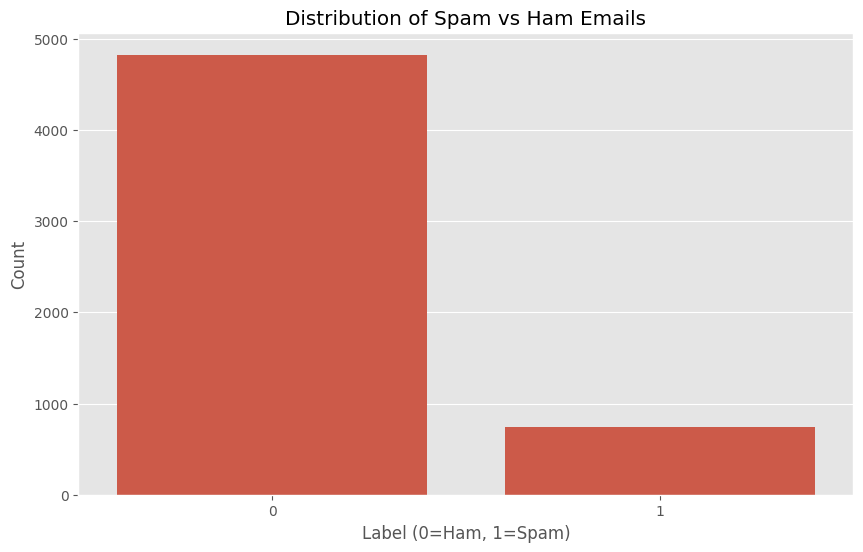

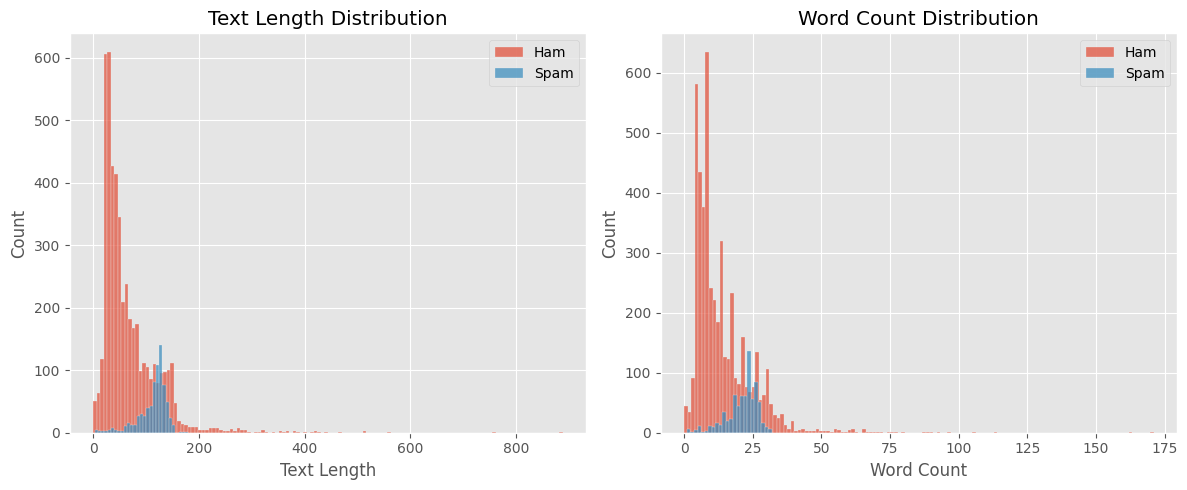

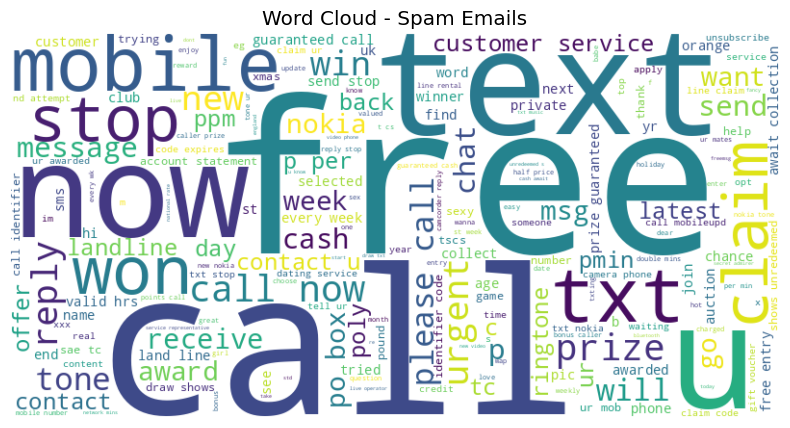

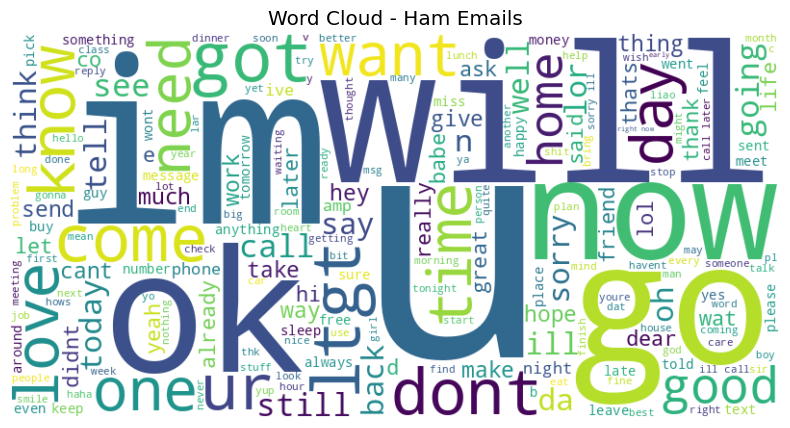

In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Emails')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.show()

# Text length analysis
df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[df['label'] == 0]['text_length'], label='Ham', alpha=0.7)
sns.histplot(df[df['label'] == 1]['text_length'], label='Spam', alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df[df['label'] == 0]['word_count'], label='Ham', alpha=0.7)
sns.histplot(df[df['label'] == 1]['word_count'], label='Spam', alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.legend()

plt.tight_layout()
plt.show()

# Word clouds for spam and ham
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds
spam_text = ' '.join(df[df['label'] == 1]['clean_text'])
ham_text = ' '.join(df[df['label'] == 0]['clean_text'])

generate_wordcloud(spam_text, 'Word Cloud - Spam Emails')
generate_wordcloud(ham_text, 'Word Cloud - Ham Emails')

# **Step 4: Feature Engineering**

In [5]:
# Split the data into training and testing sets
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Spam ratio in training: {y_train.mean():.3f}")
print(f"Spam ratio in testing: {y_test.mean():.3f}")

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=2,
    max_df=0.8
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

Training set size: 4457
Testing set size: 1115
Spam ratio in training: 0.134
Spam ratio in testing: 0.134
TF-IDF features shape: (4457, 5000)


# **Step 5: Model Selection and Training**

Naive Bayes:
  Accuracy: 0.9668
  F1 Score: 0.8582
--------------------------------------------------
Logistic Regression:
  Accuracy: 0.9659
  F1 Score: 0.8538
--------------------------------------------------
Random Forest:
  Accuracy: 0.9758
  F1 Score: 0.9011
--------------------------------------------------
SVM:
  Accuracy: 0.9839
  F1 Score: 0.9362
--------------------------------------------------

Best model: SVM

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



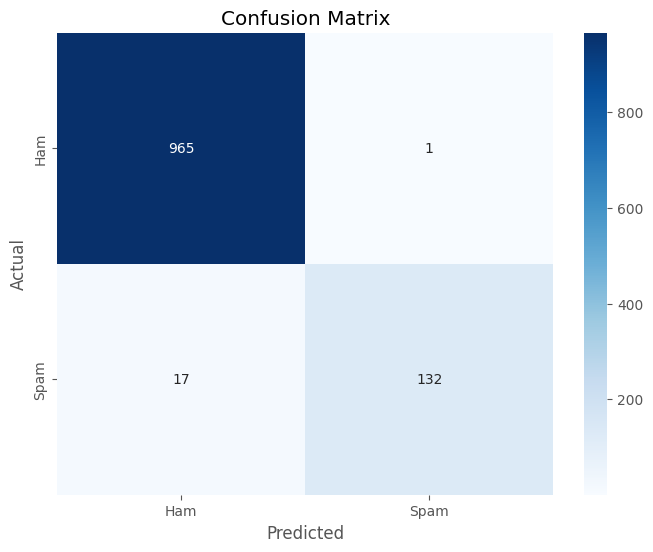

In [6]:
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear',probability=True, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'model': model
    }

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 50)

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")

# Detailed evaluation of best model
y_pred_best = best_model.predict(X_test_tfidf)
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# **Step 6: Hyperparameter Tuning (Optional)**

In [7]:
# Hyperparameter tuning for the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }

    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=42),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    grid_search.fit(X_train_tfidf, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best F1 score:", grid_search.best_score_)

    # Use the best model
    best_model = grid_search.best_estimator_

# **Step 7: Final Model Pipeline**

In [8]:
# Create a complete pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8
    )),
    ('classifier', best_model)
])

# Train the pipeline on the entire training data
pipeline.fit(X_train, y_train)

# Final evaluation
y_pred_final = pipeline.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"Final Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1 Score: {final_f1:.4f}")

# Save the model (optional)
import joblib
joblib.dump(pipeline, 'spam_classifier.pkl')

Final Model Performance:
Accuracy: 0.9839
F1 Score: 0.9362


['spam_classifier.pkl']

# **Step 8: Model Testing and Examples**

In [9]:
# Test with sample emails
sample_emails = [
    "Congratulations! You've won a free iPhone. Click here to claim your prize!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your bank account has been compromised. Verify your details immediately.",
    "Meeting reminder: Project review at 3 PM in conference room B."
]

predictions = pipeline.predict(sample_emails)
probabilities = pipeline.predict_proba(sample_emails)

print("Sample Email Predictions:")
for i, (email, pred, prob) in enumerate(zip(sample_emails, predictions, probabilities)):
    label = "SPAM" if pred == 1 else "HAM"
    confidence = prob[1] if pred == 1 else prob[0]
    print(f"{i+1}. {email}")
    print(f"   Prediction: {label} (Confidence: {confidence:.2%})")
    print()

Sample Email Predictions:
1. Congratulations! You've won a free iPhone. Click here to claim your prize!
   Prediction: SPAM (Confidence: 100.00%)

2. Hey, are we still meeting for lunch tomorrow?
   Prediction: HAM (Confidence: 99.99%)

3. URGENT: Your bank account has been compromised. Verify your details immediately.
   Prediction: SPAM (Confidence: 86.04%)

4. Meeting reminder: Project review at 3 PM in conference room B.
   Prediction: HAM (Confidence: 92.63%)



# **Step 9: Feature Importance Analysis**

Top spam indicators:
txt: 2.8378
claim: 2.2206
mobile: 1.9934
pmin: 1.9097
prize: 1.7562
ringtone: 1.7482
reply: 1.7119
won: 1.6597
games: 1.6521
landline: 1.5123
new voicemail: 1.4921
win: 1.4858
delivery: 1.4316
new: 1.4244
video: 1.4164
send stop: 1.4131
sexy: 1.4124
uk: 1.3942
guaranteed: 1.3799
poly: 1.3749

Top ham indicators:
hey: -1.1061
ltgt: -1.0618
mail: -0.9830
pa: -0.8767
ill: -0.8631
road: -0.8579
home: -0.7841
machan: -0.7783
yup: -0.7720
try: -0.7348
later: -0.7345
excellent: -0.7216
way: -0.7157
new number: -0.7121
gonna: -0.7084
customer place: -0.6995
didnt: -0.6944
knowing: -0.6863
ur mail: -0.6862
ive: -0.6799


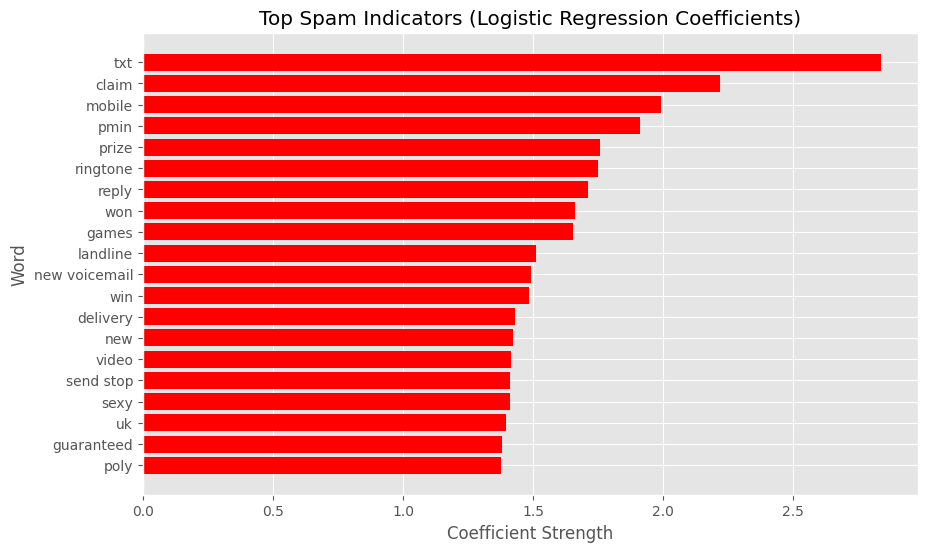

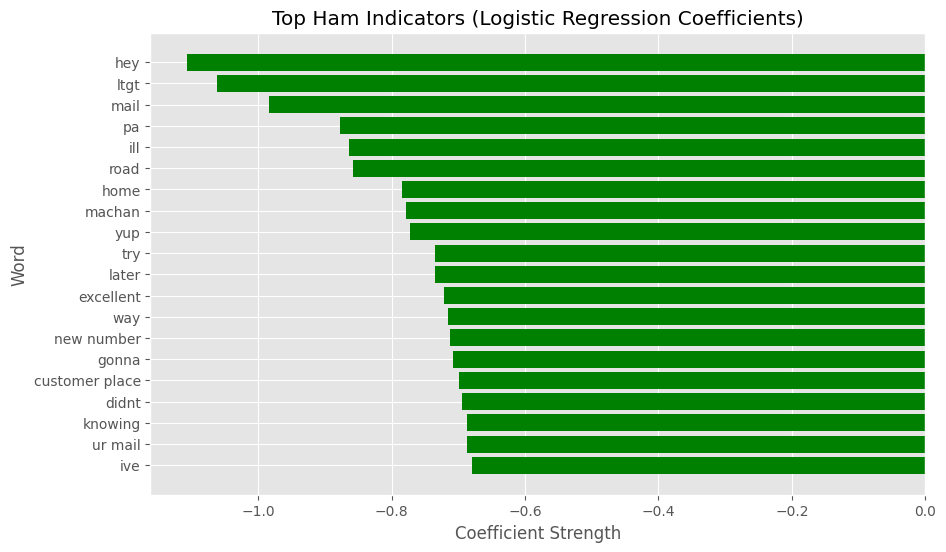

In [10]:
# For interpretable models like Logistic Regression
if hasattr(best_model, 'coef_'):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    coefficients = best_model.coef_.toarray().ravel()  # convert sparse -> dense

    # Get top spam indicators
    spam_indices = coefficients.argsort()[-20:][::-1]
    spam_words = [(feature_names[idx], coefficients[idx]) for idx in spam_indices]

    # Get top ham indicators
    ham_indices = coefficients.argsort()[:20]
    ham_words = [(feature_names[idx], coefficients[idx]) for idx in ham_indices]

    # Print top indicators
    print("Top spam indicators:")
    for word, coef in spam_words:
        print(f"{word}: {coef:.4f}")

    print("\nTop ham indicators:")
    for word, coef in ham_words:
        print(f"{word}: {coef:.4f}")

    # 🔹 Visualization for spam
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    words, coeffs = zip(*spam_words)
    plt.barh(words[::-1], coeffs[::-1], color="red")
    plt.title("Top Spam Indicators (Logistic Regression Coefficients)")
    plt.xlabel("Coefficient Strength")
    plt.ylabel("Word")
    plt.show()

    # 🔹 Visualization for ham
    plt.figure(figsize=(10,6))
    words, coeffs = zip(*ham_words)
    plt.barh(words[::-1], coeffs[::-1], color="green")
    plt.title("Top Ham Indicators (Logistic Regression Coefficients)")
    plt.xlabel("Coefficient Strength")
    plt.ylabel("Word")
    plt.show()
else:
    print("Feature importance visualization is only available for Logistic Regression.")


# **Step** 10: Interactive UI with Gradio - Without Feedback Loop

In [11]:
"""Step 10: Interactive Spam Filter UI"""

import gradio as gr
import joblib

# Load the saved model
pipeline = joblib.load("/content/spam_classifier.pkl")

# Define a prediction function
def classify_message(message):
    prediction = pipeline.predict([message])[0]
    probability = None
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        probability = pipeline.predict_proba([message])[0][prediction]
    label = "🚨 SPAM" if prediction == 1 else "✅ HAM (Not Spam)"
    confidence = f"{probability:.2%}" if probability is not None else "N/A"
    return f"**Prediction:** {label}\n**Confidence:** {confidence}"

# Create Gradio UI
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        # 📧 Spam Email Classifier
        Paste or type an email/message below and check if it's **Spam** or **Ham**.
        """
    )
    with gr.Row():
        with gr.Column(scale=2):
            input_box = gr.Textbox(
                label="Enter your email/message here",
                placeholder="Type or paste your message...",
                lines=5
            )
            classify_btn = gr.Button("Classify Message", variant="primary")
        with gr.Column(scale=1):
            output_box = gr.Markdown(label="Result")

    classify_btn.click(fn=classify_message, inputs=input_box, outputs=output_box)

# Launch the app
demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://98db25901b9ce9cba0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Step** 11: Interactive UI with Gradio - Has Feedback Loop

In [13]:
import gradio as gr
import pandas as pd
import os
import joblib

# Paths
MODEL_PATH = "spam_classifier.pkl"
FEEDBACK_FILE = "feedback.csv"

# Load saved model
pipeline = joblib.load(MODEL_PATH)

# Ensure feedback file exists
if not os.path.exists(FEEDBACK_FILE):
    pd.DataFrame(columns=["Message", "Model_Prediction", "User_Label"]).to_csv(FEEDBACK_FILE, index=False)

# Classification function
def classify_message(message):
    prediction = pipeline.predict([message])[0]
    label = "SPAM" if prediction == 1 else "HAM"
    return label

# Feedback storage function
def store_feedback(message, model_prediction, user_label):
    if user_label not in ["SPAM", "HAM"]:
        return "⚠️ Please select Spam or Ham before submitting."

    df = pd.read_csv(FEEDBACK_FILE)
    new_row = {"Message": message, "Model_Prediction": model_prediction, "User_Label": user_label}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv(FEEDBACK_FILE, index=False)
    return f"✅ Feedback saved! ({user_label})"

# Optional retrain function
def retrain_model():
    try:
        # Load feedback
        feedback_df = pd.read_csv(FEEDBACK_FILE)
        if feedback_df.empty:
            return "⚠️ No feedback available for retraining."

        # Load original dataset (adjusted to your file structure)
        df = pd.read_csv("/content/spam.csv", encoding="latin-1")

        # Check column names and normalize
        if "Category" in df.columns and "Message" in df.columns:
            df = df[['Category', 'Message']]
            df.columns = ['label', 'text']
            df['label'] = df['label'].map({'ham': 0, 'spam': 1})
        elif "label" in df.columns and "text" in df.columns:
            pass  # already cleaned
        else:
            return f"⚠️ Unexpected dataset format. Found columns: {df.columns.tolist()}"

        # Prepare feedback dataset
        feedback_df['label'] = feedback_df['User_Label'].map({'HAM': 0, 'SPAM': 1})
        feedback_df = feedback_df[['Message', 'label']]
        feedback_df.columns = ['text', 'label']

        # Combine datasets
        full_data = pd.concat([df, feedback_df], ignore_index=True)

        # Retrain pipeline
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.linear_model import LogisticRegression
        from sklearn.pipeline import Pipeline

        pipeline_new = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ])

        pipeline_new.fit(full_data['text'], full_data['label'])

        # Save updated model
        joblib.dump(pipeline_new, MODEL_PATH)

        return f"✅ Model retrained successfully with {len(feedback_df)} feedback samples added!"

    except Exception as e:
        return f"❌ Error during retraining: {str(e)}"


# Gradio UI
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 📧 Spam Classifier with Feedback Loop")

    with gr.Row():
        input_box = gr.Textbox(label="Enter your message", lines=3, placeholder="Paste a message here...")

    with gr.Row():
        classify_btn = gr.Button("Classify Message", variant="primary")
        output_box = gr.Textbox(label="Model Prediction", interactive=False)

    gr.Markdown("### 📝 Provide Feedback")
    feedback_choice = gr.Radio(choices=["SPAM", "HAM"], label="Correct Label")
    feedback_btn = gr.Button("Submit Feedback", variant="secondary")
    feedback_status = gr.Textbox(label="Feedback Status", interactive=False)

    retrain_btn = gr.Button("Retrain Model with Feedback", variant="primary")
    retrain_status = gr.Textbox(label="Retraining Status", interactive=False)

    # Events
    classify_btn.click(fn=classify_message, inputs=input_box, outputs=output_box)
    feedback_btn.click(fn=store_feedback, inputs=[input_box, output_box, feedback_choice], outputs=feedback_status)
    retrain_btn.click(fn=retrain_model, outputs=retrain_status)

# Launch
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a1d47c0590996b9c63.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
